In [50]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 



from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature
sys.path.append('../src')

#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import plot_confusion_matrix
from utils import plot_classification_report
from utils import interquartile

import pickle
from zenodo_get import zenodo_get

#import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Loading the Tsfel Features

In [51]:
# These waveforms are filtered between 1-10 Hz
# extracting features of surface events, thunder and sonic booms
features_exotic_tsfel = pd.read_csv('../extracted_features/tsfel_features_exotic_P_10_30_F_1_15_50.csv')


# features of noise
features_noise_tsfel = pd.read_csv('../extracted_features/tsfel_features_noise_P_10_30_F_1_15_50.csv')


# features of explosion
features_explosion_tsfel = pd.read_csv('../extracted_features/tsfel_features_explosion_P_10_30_F_1_15_50.csv')


# features of earthquake (had to extract it in three parts because of memory constraints)
features_eq1 = pd.read_csv('../extracted_features/tsfel_features_earthquake_part_1_P_10_30_F_1_15_50.csv')
features_eq2 = pd.read_csv('../extracted_features/tsfel_features_earthquake_part_2_P_10_30_F_1_15_50.csv')
features_eq3 = pd.read_csv('../extracted_features/tsfel_features_earthquake_part_3_P_10_30_F_1_15_50.csv')
features_eq4 = pd.read_csv('../extracted_features/tsfel_features_earthquake_part_3_P_10_30_F_1_15_50.csv')

# features of earthquakes
features_earthquake_tsfel = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

## Loading the physical features

In [52]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('../extracted_features/physical_features_exotic_P_10_30_F_1_15_50.csv')

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('../extracted_features/physical_features_noise_P_10_30_F_1_15_50.csv')


# features of explosion
features_explosion_physical = pd.read_csv('../extracted_features/physical_features_explosion_P_10_30_F_1_15_50.csv')

# features of earthquakes
features_eq1 = pd.read_csv('../extracted_features/physical_features_earthquake_part_1_P_10_30_F_1_15_50.csv')
features_eq2 = pd.read_csv('../extracted_features/physical_features_earthquake_part_2_P_10_30_F_1_15_50.csv')
features_eq3 = pd.read_csv('../extracted_features/physical_features_earthquake_part_3_P_10_30_F_1_15_50.csv')
features_eq4 = pd.read_csv('../extracted_features/physical_features_earthquake_part_4_P_10_30_F_1_15_50.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

## Merging tsfel and physical features for each event. 
Each event is identified by its unique serial number. 

In [53]:
## Merging tsfel and physical features

features_noise = pd.merge(features_noise_physical, features_noise_tsfel, on = 'serial_no')
features_earthquake = pd.merge(features_earthquake_physical, features_earthquake_tsfel, on = 'serial_no')
features_explosion = pd.merge(features_explosion_physical, features_explosion_tsfel, on = 'serial_no')

features_surface_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface']
features_sonic_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'sonic']
features_thunder_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'thunder']

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']


features_surface = pd.merge(features_surface_physical, features_surface_tsfel, on = 'serial_no')
features_sonic = pd.merge(features_sonic_physical, features_sonic_tsfel, on = 'serial_no')
features_thunder = pd.merge(features_thunder_physical, features_thunder_tsfel, on = 'serial_no')



features_all = pd.concat([features_surface, features_noise, features_explosion, features_earthquake])



print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 260028 events and each event have 457 features


## So in the features_all dataframe, the first column is "Unnamed:0_x", which is a useless artifact entered when merging the dataframes, next 63 columns are physical features, these are followed by columns of serial_no and source, and then there are 390 tsfel features

# In the following cells we are going to remove the uncessary features and outliers. 

It is a very important step to clean the input data before applying machine learning algorithms. 

## 1. Removing highly correlated features
Highly correlated features carry redundant information. This redundancy does not add any new information to the model but can lead to overfitting. Overfitting occurs when the model learns the noise in the training data rather than the actual signal, which reduces its generalizability to new data. So first, we will identify the features that are highly correlated to each other (cc > 0.95) and only select one of these features.

In [54]:
serial_nos = features_all['serial_no'].values
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x', 'serial_no'], axis = 1, errors = 'ignore')
features_all.rename(columns={'source_y': 'source'}, inplace=True)
corr_features = tsfel.correlated_features(features_all.iloc[:, 1:453])

features_all.drop(corr_features, axis=1, inplace=True)
features_all['serial_no'] = serial_nos
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 260028 events and each event have 385 features


## 2. Dropping all the columns that contains infinity or nan values for any event. 
Many statistical operations, such as calculating means, variances, and covariances, do not work properly with NaN or infinity values. This can lead to incorrect parameter estimates and unreliable statistical inferences.

In [55]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()

## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 258642 events and each event have 384 features


## 3. Removing the features that have the same values for all the features. 
It is important to remove such features since they are not actually contributing in anything but are unnecessarily increasing the computational time. 

In [56]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 258642 events and each event have 368 features


## 4. Removing the outliers based on z-score
Only retaining those events that have the values of all their features lying with 4 times of standard deviations for each features. 

In [57]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 10

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 235850 events and each event have 368 features


## Standardizing the features

The StandardScaler is a preprocessing tool provided by the scikit-learn library in Python. It standardizes features by removing the mean and scaling to unit variance. This process is essential for many machine learning algorithms, particularly those that rely on the distance between data points, such as k-nearest neighbors (KNN), principal component analysis (PCA), and gradient descent optimization in neural networks.

In [58]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)

# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

## Hyperparameter tuning of the model

Hyperparameter tuning is the process of optimizing the hyperparameters of a machine learning model to improve its performance. Hyperparameters are the parameters that are not learned from the data but are set before the training process begins, such as the learning rate, number of trees in a random forest, or the regularization parameter in a regression model.


We will use **Randomized Grid Search** for hyperparameter tuning. RandomizedSearchCV is a hyperparameter optimization technique provided by scikit-learn. It samples a fixed number of hyperparameter settings from specified distributions and evaluates them using cross-validation. This method is generally faster than GridSearchCV because it does not evaluate all possible combinations of hyperparameters, but instead, it searches through a subset of the hyperparameter space.




We will sample 3000  random samples per class, split it into 80-20% and tune our model to find the model that provides the best performance. 


**We are going to tune the parameters of random forests**
These hyperparameters control various aspects of the Random Forest algorithm:

- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required at a leaf node.
- max_features: Number of features to consider for the best split.
- bootstrap: Whether to use bootstrap samples.


**Optimizing these parameters helps in finding the best trade-off between bias and variance, ultimately improving the model's performance and generalization to unseen data.**


## Note this process will take about 5 - 7 minutes

In [59]:
init_time = time.time()

## Defining the features dataframe. 
temp_X = X_scaled.iloc[:,0:int(np.where(X_scaled.columns == 'serial_no')[0])]


# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)





# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)



# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv= 10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)





print(time.time() - init_time)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Accuracy: 0.934439916544
Test Accuracy: 0.9325
341.9183597564697


## Plotting the confusion matrix and classification report for the best model found above.


A **confusion matrix** is a table used to evaluate the performance of a classification algorithm. It provides a comprehensive summary of the prediction results by comparing the predicted and actual classes. The matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), which are essential for understanding how well the model performs in terms of accuracy, precision, recall, and other metrics.

A **classification report** is a detailed summary of the performance of a classification algorithm, which includes key metrics such as precision, recall, F1-score, and support for each class. This report is especially useful for evaluating the effectiveness of a model on a classification problem, providing a more granular view of performance across different classes.


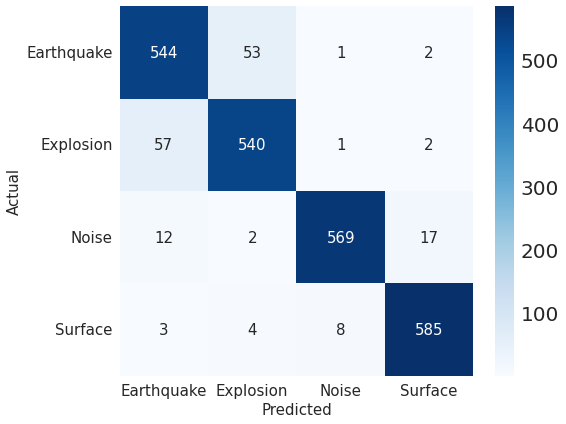

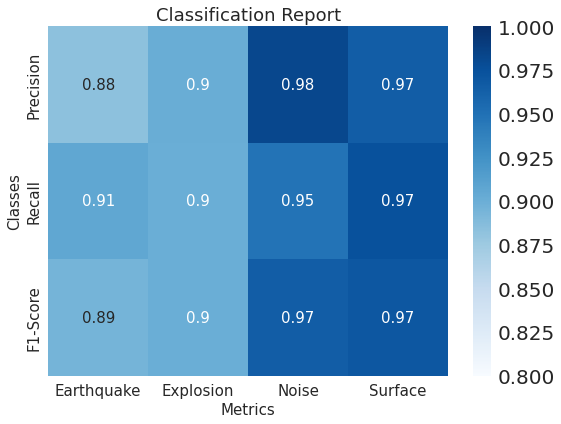

In [60]:
## plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)


# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report(report)

## Computing the feature importance

Feature importance refers to techniques that assign scores to input features based on their relevance in predicting the target variable. Understanding feature importance helps in interpreting models, reducing dimensionality, and improving model performance by focusing on the most impactful features.

In Random Forests, feature importance is calculated based on how much each feature contributes to reducing the impurity (e.g., Gini impurity or entropy) of the nodes in the decision trees. During training, each tree in the forest is built using a subset of the data and a random selection of features. The importance of a feature is determined by measuring the decrease in impurity that it causes when used for splitting nodes in the tree. Features that lead to large impurity decreases across all trees in the forest are considered more important, as they play a significant role in the model's ability to make accurate predictions. These importance scores are then averaged across all trees to determine the final importance of each feature, which can be used to understand the relative contribution of different features to the model's performance.

## We will compute the feature importance scores 10 times and average the results for final importance estimation. (It will take 5 - 7 minutes)

In [61]:
num_iter = 10
f_imp = []

for i in tqdm(range(num_iter)):

    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
    X_resampled, y_resampled = rus.fit_resample(temp_X, y)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)

    # Perform randomized grid search cross-validation
    best_model.fit(X_train, y_train)


    f_imp.append(best_model.feature_importances_)

100%|██████████| 10/10 [07:28<00:00, 44.88s/it]


## Plotting the feature importance

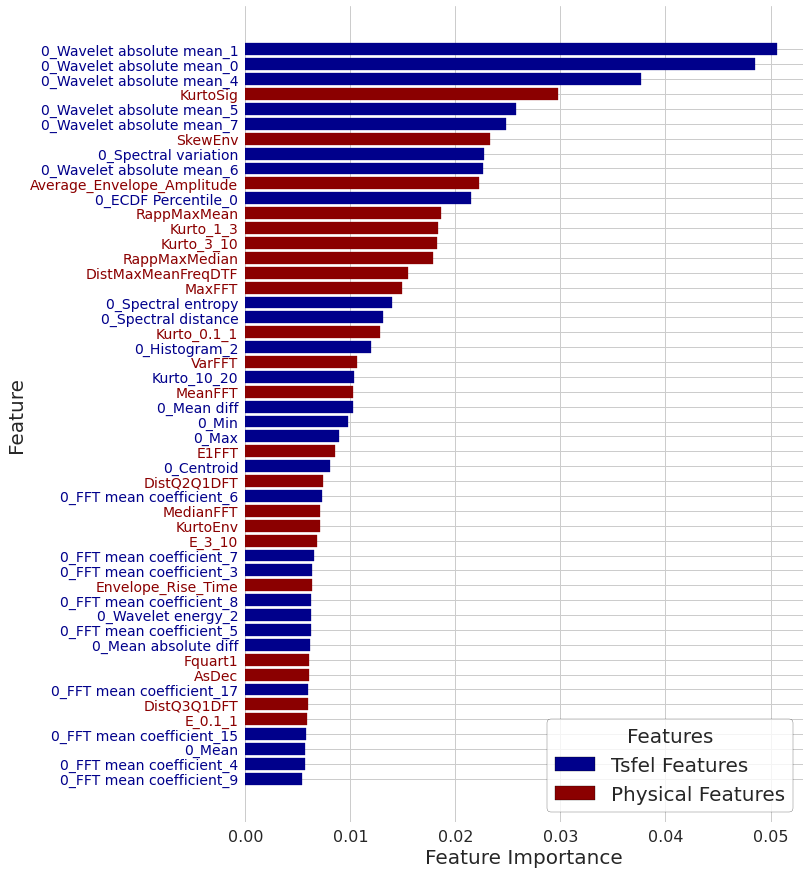

In [62]:
## Averaging the feature importance. 
final_imp = np.mean(f_imp, axis = 0)
features = X_train.columns.values
feature_colors = ['darkred']*49+['darkblue']*(len(features)-49)  # red for physical and blue for tsfel features. 

## Removing the 0 from the starting of each feature name
## the second argument in split specifies the maxsplit, the amount of times the split will be performed. 
#feature_names = np.hstack([features[0:49],[features[49:][i].split('_', 1)[1] for i in range(len(features[49:]))]])




# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels



# Sample feature importances and feature labels
feature_importances = final_imp
feature_labels = features

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]
colors = [feature_colors[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 15))
bars = plt.barh(sorted_feature_labels[0:50], sorted_feature_importances[0:50])

# Color bars to match yticklabels
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Color yticklabels and increase font size
for label, color in zip(plt.gca().get_yticklabels(), colors):
    label.set_color(color)
    #label.set_fontsize(20)  # Set desired font size here

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='darkblue', ec='black'), plt.Rectangle((0,0),1,1, color='darkred', ec='black')]
legend_labels = ['Tsfel Features', 'Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', title_fontsize=20, frameon=True, fontsize = 20, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
#plt.title('Top 50 Feature Importances', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Set y-axis tick label size
plt.yticks(fontsize=14)

plt.show()





## Merging the metadata information with the extracted features

In [63]:
# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']

# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp

df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq

df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no

df_su = X_scaled[X_scaled['source'] == 'surface']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su


new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)



/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Extracting hour of the day, day of the week and month of the year
We will see if including these manual features would improve the model performance. The main intuition behind including these features is to improving the discrimination between earthquakes and explosions. The explosions always occur during the day. 

In [64]:
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 327802/327802 [00:02<00:00, 147152.54it/s]


## For each event, there are two kinds of labels, USGS ANSS source label and PNSN source label. The PNSN first reviews events and assign a label that include various varieties of earthquakes, explosions and surface events, these labels are then merged into categories of earthquakes and explosions

Text(0.5, 0, 'Labels assigned by PNSN')

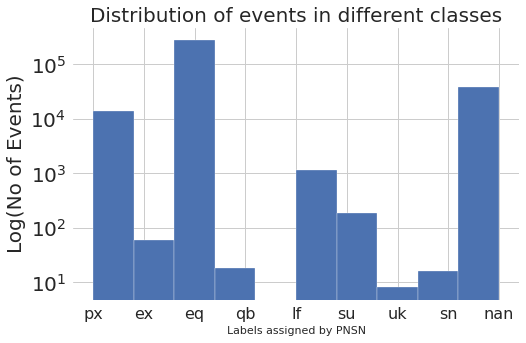

In [65]:
plt.figure(figsize = [8, 5])
plt.hist(X_final['source_type_pnsn_label'].astype('str'), align = 'mid')

plt.yscale('log')
plt.title('Distribution of events in different classes', fontsize = 20)
plt.ylabel('Log(No of Events)', fontsize = 20)
plt.xlabel('Labels assigned by PNSN')

### Explanation of PNSN labels


- px - probable blast , 'explosion' (USGS)
- ex - confirmed explosion, 'explosion' (USGS)
- eq - earthquake, 'earthquake' (USGS)
- qb - quarry blast, 'explosion' (USGS)
- lf - low frequency earthquakes (USGS)
- su - surface event, 'Surface event' (USGS)
- uk - unknown, 'Earthquake' (USGS)
- sn - 
- nan - noise is not a part of pnsn label



In this case, we will only select "px" for the explosions

## Training the model on 5000 random events (with replacement) per class and testing on the remaining dataset

In [66]:
## extracting metadata information for each kind of source along with features
## source_type_pnsn_label is more reliable label. 


# selecting all the earthquakes and their metadata information. 
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']



## removing the ambiguous events, these are the events that were assigned as earthquakes by pnsn but labelled as
## explosion in USGS ANSS catalog. 
a_eq = a_eq[a_eq['source_type'] != 'explosion']


## selecting all the explosions specifically px, (which is mainly quarry blasts)
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
# removing the ambiguous events. 
a_px = a_px[a_px['source_type'] != 'earthquake']

a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



# Extract event IDs for each source type
eq_ids, px_ids, su_ids, no_ids = (
    np.unique(a['event_id'].values) for a in [a_eq, a_px, a_su, a_no]
)



## Specifying a random seed for the reproducibility. 
np.random.seed(123) 


## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

## Model training and Evaluation

## Case 1: Without adding manual features

In [67]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
#x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
#x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



## We will train the model on 5000 randomly selected samples and test on all the remaining

In [68]:
# initiating a random undersampler
# we have also specified a random state for reproducibility


# number of samples per each event. 
nus = 5000
rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus,'surface event':nus,'noise':nus}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_split=5, n_estimators=200, random_state=42)

## Plotting trace wise performance

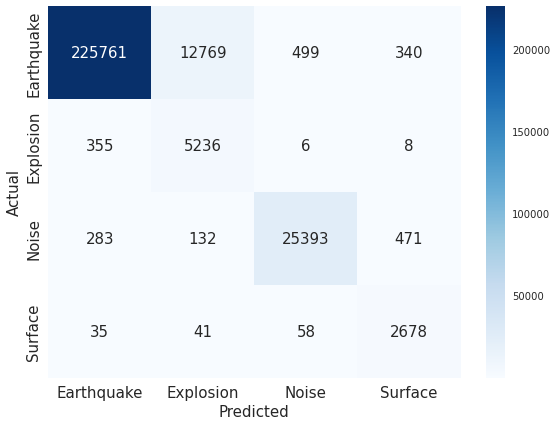

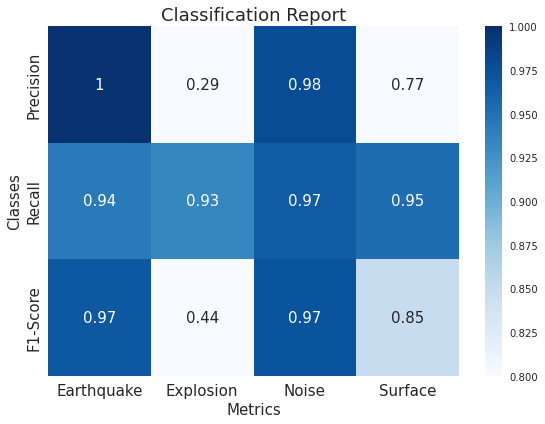

In [69]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(trace_cm_phy_tsf)


# Calculate the classification report
trace_report_phy_tsf = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(trace_report_phy_tsf)


## Plotting Event Wise performance

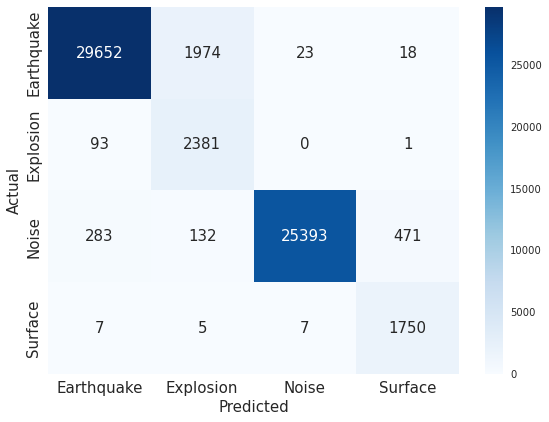

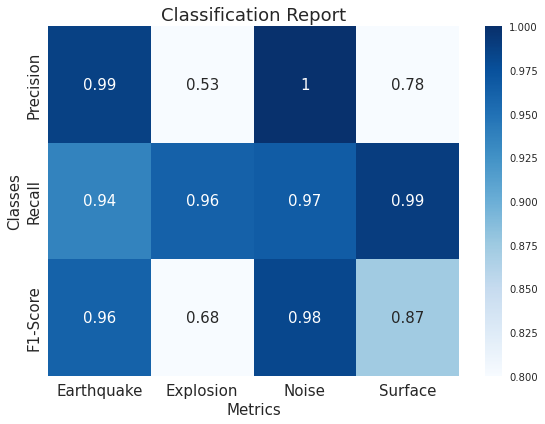

In [70]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy_tsf = confusion_matrix(mean_labels, temp_class)
plot_confusion_matrix(cf_events_phy_tsf)


# Calculate the classification report
report_event_phy_tsf = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(report_event_phy_tsf)
